# Summary of end results:

***Multinomial Naive Bayes best results***

| Dataset   | StopWords | tf-(idf) | ngram_range | alpha | Top1 Acc. |
|-----------|-----------|----------|-------------|-------|-----------|
| Wikipedia | 'english' | Use idf  | (1, 1)      | 1     | 0.738     |
| ArXiv     | 'english' | Use idf  | (1, 1)      | 0.1   | 0.425     |

***Support Vector Machine best results***

| Dataset   | StopWords | tf-(idf) | ngram_range | C     | gamma | Top1 Acc. |
|-----------|-----------|----------|-------------|-------|-------|-----------|
| Wikipedia | 'english' | Use idf  | (1, 1)      | 0.001 | 0.001 | 0.734     |
| ArXiv     | 'english' | Use idf  | (1, 1)      | 0.001 | 0.001 | 0.415     |



**FFNN** (*Wikipedia* articles data): **0.42**

**FFNN** (*Arxiv* papers data): **0.25**

#Libraries

### 3rd Party Libraries

In [0]:
!pip install wikipedia
!pip install wikipedia-api

In [1]:
#Keras Neural Network (Feedforward)
from keras.backend import clear_session
from keras.models import Sequential
from keras.layers import Dense
#Computations 
import numpy as np
#Progress bar
from tqdm import tqdm_notebook as tqdm 

#Sklearn classifiers and utils
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

#visualizing 
import pandas as pd
from google.colab.data_table import DataTable

Using TensorFlow backend.


### Project Library (modules)

In [3]:
import doc_utils #cleaning and other helper functions
from max_sim_classifier import MaxSimClassifier #maximum similarity classifier custom library

#Parser libraries: wikipedia dataset and arxiv dataset
from arxiv_parser import arxiv_parser
from wiki_parser import concurrentGetWikiFullPage, concurrentGetAllCatArticles

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data retrieval: Wiki and ArXiv datasets

## Wikipedia Dataset (Definitions + Articles)

In [4]:
engineering_topic_defs = concurrentGetWikiFullPage(topics_list = doc_utils.ALL_TOPICS )

engineering_articles, n_test_samples = concurrentGetAllCatArticles(doc_utils.ALL_TOPICS, full_text_test=True)

Obtaining full wikipedia page for the topic: Chemical engineering. (Definition of Class #[0])
Obtaining full wikipedia page for the topic: Biomedical engineering. (Definition of Class #[1])
Obtaining full wikipedia page for the topic: Civil engineering. (Definition of Class #[2])
Obtaining full wikipedia page for the topic: Electrical engineering. (Definition of Class #[3])
Obtaining full wikipedia page for the topic: Mechanical engineering. (Definition of Class #[4])
Obtaining full wikipedia page for the topic: Aerospace engineering. (Definition of Class #[5])
Obtaining full wikipedia page for the topic: Software engineering. (Definition of Class #[6])
Obtaining full wikipedia page for the topic: Industrial engineering. (Definition of Class #[7])Obtaining full wikipedia page for the topic: Computer engineering. (Definition of Class #[8])

Retrieved 41 articles from category topic 'Computer engineering'[TopicID:8]
Retrieved 57 articles from category topic 'Software engineering'[TopicID

Mean number of words per topic definition: 3192.3333333333335


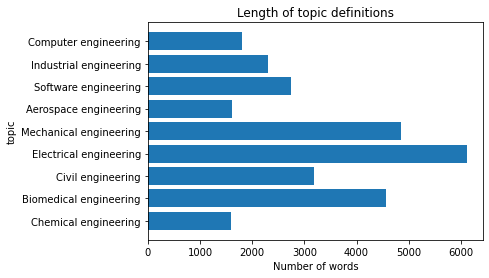

In [5]:
doc_utils.plotDefinitionLengths(engineering_topic_defs ,dataset_type="wiki")

## arXiv Dataset (Papers)

In [6]:
arxiv_topic_defs = concurrentGetWikiFullPage(topics_list = doc_utils.ARXIV_WIKI_TOPICS)

arxiv_papers = arxiv_parser(100)

Obtaining full wikipedia page for the topic: Computer science. (Definition of Class #[0])
Obtaining full wikipedia page for the topic: Economics. (Definition of Class #[1])
Obtaining full wikipedia page for the topic: Systems engineering. (Definition of Class #[2])
Obtaining full wikipedia page for the topic: Mathematics. (Definition of Class #[3])
Obtaining full wikipedia page for the topic: Astrophysics. (Definition of Class #[4])
Obtaining full wikipedia page for the topic: Computational biology. (Definition of Class #[5])
Obtaining full wikipedia page for the topic: Quantitative finance. (Definition of Class #[6])
Obtaining full wikipedia page for the topic: Statistics. (Definition of Class #[7])
Retrieved 800 papers in total from 8 subjects (100 from each).


Mean number of words per topic definition: 3692.375


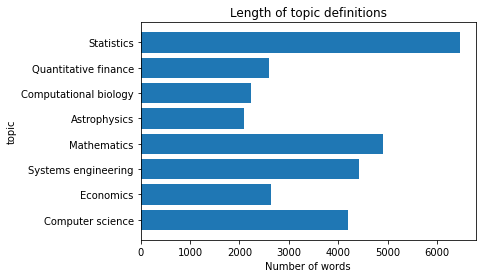

In [7]:
doc_utils.plotDefinitionLengths(arxiv_topic_defs ,dataset_type="arxiv")

#Hyperparam search of SVM and MNB baseline models

##ArXiv dataset

In [0]:
x_train, y_train, x_test, y_test = doc_utils.processClassifierData(arxiv_topic_defs, 
                                                                   arxiv_papers,
                                                                   topics = doc_utils.ARXIV_WIKI_TOPICS,
                                                                   dataset_type ="arxiv")

### Support Vector Machine classifier

In [0]:
from sklearn.svm import SVC

best_svm_arxiv_score = 0
svm_arxiv_models_params = list()

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        for idf in [True, False]:
            for stop_words in ['english', None]:
                for ngram_range in [(1,1), (1,2)]:
                    # for each combination of parameters, train an SVC
                    svm = Pipeline([('vect', CountVectorizer(stop_words=stop_words,ngram_range=ngram_range)),
                                    ('tfidf', TfidfTransformer(use_idf=idf)),
                                    ('clf', SVC(C=C, gamma=gamma)),
                                    ])    
                    svm.fit(x_train, y_train)
                    # evaluate the SVC on the test set
                    score = svm.score(x_test, y_test)

                    #keeping track of the combinations
                    params = {'C': C, 'gamma': gamma, 'idf': idf, 'stop_words':stop_words, 'ngram_range':ngram_range}
                    svm_arxiv_models_params.append((score, params))

                    # if we got a better score, store the score and parameters
                    if score > best_svm_arxiv_score:
                        best_svm_arxiv_score = score
                        best_svm_arxiv_parameters = {'C': C, 'gamma': gamma, 'idf': idf, 'stop_words':stop_words, 'ngram_range':ngram_range}

print("Best score: {:.2f}".format(best_svm_arxiv_score))
print("Best parameters: {}".format(best_svm_arxiv_parameters))

Best score: 0.41
Best parameters: {'C': 0.001, 'gamma': 0.001, 'idf': True, 'stop_words': 'english', 'ngram_range': (1, 2)}


In [0]:
df = pd.DataFrame.from_dict(svm_arxiv_models_params)
df.columns = ['Top1 Acc.', 'SVM Classifier Parameters']
DataTable(df.sort_values(by=['Top1 Acc.'], ascending=False))

,Top1 Acc.,SVM Classifier Parameters
65,0.41500,"{'C': 0.1, 'gamma': 0.01, 'idf': True, 'stop_w..."
217,0.41500,"{'C': 1, 'gamma': 10, 'idf': True, 'stop_words..."
129,0.41500,"{'C': 10, 'gamma': 0.1, 'idf': True, 'stop_wor..."
201,0.41500,"{'C': 0.01, 'gamma': 10, 'idf': True, 'stop_wo..."
25,0.41500,"{'C': 1, 'gamma': 0.001, 'idf': True, 'stop_wo..."
...,...,...
223,0.20125,"{'C': 1, 'gamma': 10, 'idf': False, 'stop_word..."
231,0.20125,"{'C': 10, 'gamma': 10, 'idf': False, 'stop_wor..."
15,0.20125,"{'C': 0.01, 'gamma': 0.001, 'idf': False, 'sto..."
239,0.20125,"{'C': 100, 'gamma': 10, 'idf': False, 'stop_wo..."


### Multinomial Naive Bayes classifier

In [0]:
best_mnb_arxiv_score = 0
best_mnb_arxiv_parameters = list()

mnb_arxiv_models_params = list()

for alpha in [0.001, 0.01, 0.1, 1]:
    for idf in [True, False]:
        for stop_words in ['english', None]:
            for ngram_range in [(1,1), (1,2)]:
                # for each combination of parameters, train an SVC
                mnb = Pipeline([('vect', CountVectorizer(stop_words=stop_words,ngram_range=ngram_range)),
                                ('tfidf', TfidfTransformer(use_idf=idf)),
                                ('clf', MultinomialNB(alpha=alpha)),
                                ])    
                mnb.fit(x_train, y_train)
                # evaluate the SVC on the test set
                score = mnb.score(x_test, y_test)

                params = {'alpha': alpha, 'idf': idf, 'stop_words':stop_words, 'ngram_range':ngram_range}
                mnb_arxiv_models_params.append((score, params))
                # if we got a better score, store the score and parameters
                if score > best_mnb_arxiv_score:
                    best_mnb_arxiv_score = score
                    best_mnb_arxiv_parameters = {'alpha': alpha, 'idf': idf, 'stop_words':stop_words, 'ngram_range':ngram_range}

print("Best score: {:.2f}".format(best_mnb_arxiv_score))
print("Best parameters: {}".format(best_mnb_arxiv_parameters))

Best score: 0.42
Best parameters: {'alpha': 0.1, 'idf': True, 'stop_words': 'english', 'ngram_range': (1, 1)}


In [0]:
df = pd.DataFrame.from_dict(mnb_arxiv_models_params)
df.columns = ['Top1 Acc.', 'Multinomial NB Classifier Parameters']
DataTable(df.sort_values(by=['Top1 Acc.'], ascending=False))

,Top1 Acc.,Multinomial NB Classifier Parameters
16,0.42500,"{'alpha': 0.1, 'idf': True, 'stop_words': 'eng..."
25,0.42125,"{'alpha': 1, 'idf': True, 'stop_words': 'engli..."
17,0.41875,"{'alpha': 0.1, 'idf': True, 'stop_words': 'eng..."
24,0.41750,"{'alpha': 1, 'idf': True, 'stop_words': 'engli..."
8,0.41625,"{'alpha': 0.01, 'idf': True, 'stop_words': 'en..."
9,0.40875,"{'alpha': 0.01, 'idf': True, 'stop_words': 'en..."
1,0.40750,"{'alpha': 0.001, 'idf': True, 'stop_words': 'e..."
13,0.39375,"{'alpha': 0.01, 'idf': False, 'stop_words': 'e..."
0,0.39375,"{'alpha': 0.001, 'idf': True, 'stop_words': 'e..."
10,0.39125,"{'alpha': 0.01, 'idf': True, 'stop_words': Non..."


## Wikipedia dataset

In [0]:
x_train, y_train, x_test, y_test = doc_utils.processClassifierData(engineering_topic_defs, 
                                                                   engineering_articles,
                                                                   topics = doc_utils.ALL_TOPICS,
                                                                   dataset_type ="wiki")

### Support Vector Machine classifier

In [0]:
best_svm_wiki_score = 0
svm_wiki_models_params = list()
for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        for idf in [True, False]:
            for stop_words in ['english', None]:
                for ngram_range in [(1,1), (1,2)]:
                    # for each combination of parameters, train an SVC
                    svm = Pipeline([('vect', CountVectorizer(stop_words=stop_words,ngram_range=ngram_range)),
                                    ('tfidf', TfidfTransformer(use_idf=idf)),
                                    ('clf', SVC(C=C, gamma=gamma)),
                                    ])    
                    svm.fit(x_train, y_train)
                    # evaluate the SVC on the test set
                    score = svm.score(x_test, y_test)

                    #keeping track of the combinations
                    params = {'C': C, 'gamma': gamma, 'idf': idf, 'stop_words':stop_words, 'ngram_range':ngram_range}
                    svm_wiki_models_params.append((score, params))

                    # if we got a better score, store the score and parameters
                    if score > best_svm_wiki_score:
                        best_svm_wiki_score = score
                        best_svm_wiki_parameters = {'C': C, 'gamma': gamma, 'idf': idf, 'stop_words':stop_words, 'ngram_range':ngram_range}

print("Best score: {:.2f}".format(best_svm_wiki_score))
print("Best parameters: {}".format(best_svm_wiki_parameters))

Best score: 0.73
Best parameters: {'C': 0.001, 'gamma': 0.001, 'idf': True, 'stop_words': 'english', 'ngram_range': (1, 1)}


In [0]:
df = pd.DataFrame.from_dict(svm_wiki_models_params)
df.columns = ['Top1 Acc.', 'SVM Classifier Parameters']
DataTable(df.sort_values(by=['Top1 Acc.'], ascending=False))

,Top1 Acc.,SVM Classifier Parameters
0,0.734406,"{'C': 0.001, 'gamma': 0.001, 'idf': True, 'sto..."
32,0.734406,"{'C': 10, 'gamma': 0.001, 'idf': True, 'stop_w..."
48,0.734406,"{'C': 0.001, 'gamma': 0.01, 'idf': True, 'stop..."
56,0.734406,"{'C': 0.01, 'gamma': 0.01, 'idf': True, 'stop_..."
64,0.734406,"{'C': 0.1, 'gamma': 0.01, 'idf': True, 'stop_w..."
...,...,...
183,0.307847,"{'C': 10, 'gamma': 1, 'idf': False, 'stop_word..."
87,0.307847,"{'C': 10, 'gamma': 0.01, 'idf': False, 'stop_w..."
223,0.307847,"{'C': 1, 'gamma': 10, 'idf': False, 'stop_word..."
7,0.307847,"{'C': 0.001, 'gamma': 0.001, 'idf': False, 'st..."


### Multinomial Naive Bayes classifier

In [0]:
best_mnb_wiki_score = 0
mnb_wiki_models_params = list()
for alpha in [0.001, 0.01, 0.1, 1]:
    for idf in [True, False]:
        for stop_words in ['english', None]:
            for ngram_range in [(1,1), (1,2)]:
                # for each combination of parameters, train an SVC
                mnb = Pipeline([('vect', CountVectorizer(stop_words=stop_words,ngram_range=ngram_range)),
                                ('tfidf', TfidfTransformer(use_idf=idf)),
                                ('clf', MultinomialNB(alpha=alpha)),
                                ])    
                mnb.fit(x_train, y_train)
                # evaluate the SVC on the test set
                score = mnb.score(x_test, y_test)

                params = {'alpha': alpha, 'idf': idf, 'stop_words':stop_words, 'ngram_range':ngram_range}
                mnb_wiki_models_params.append((score, params))
                # if we got a better score, store the score and parameters
                if score > best_mnb_wiki_score:
                    best_mnb_wiki_score = score
                    best_mnb_wiki_parameters = {'alpha': alpha, 'idf': idf, 'stop_words':stop_words, 'ngram_range':ngram_range}

print("Best score: {:.2f}".format(best_mnb_wiki_score))
print("Best parameters: {}".format(best_mnb_wiki_parameters))

Best score: 0.74
Best parameters: {'alpha': 1, 'idf': True, 'stop_words': 'english', 'ngram_range': (1, 1)}


In [0]:
df = pd.DataFrame.from_dict(mnb_wiki_models_params)
df.columns = ['Top1 Acc.', 'Multinomial NB Classifier Parameters']
DataTable(df.sort_values(by=['Top1 Acc.'], ascending=False))

,Top1 Acc.,Multinomial NB Classifier Parameters
24,0.738431,"{'alpha': 1, 'idf': True, 'stop_words': 'engli..."
25,0.737425,"{'alpha': 1, 'idf': True, 'stop_words': 'engli..."
17,0.737425,"{'alpha': 0.1, 'idf': True, 'stop_words': 'eng..."
16,0.732394,"{'alpha': 0.1, 'idf': True, 'stop_words': 'eng..."
9,0.710262,"{'alpha': 0.01, 'idf': True, 'stop_words': 'en..."
8,0.697183,"{'alpha': 0.01, 'idf': True, 'stop_words': 'en..."
29,0.691147,"{'alpha': 1, 'idf': False, 'stop_words': 'engl..."
21,0.689135,"{'alpha': 0.1, 'idf': False, 'stop_words': 'en..."
13,0.685111,"{'alpha': 0.01, 'idf': False, 'stop_words': 'e..."
20,0.681087,"{'alpha': 0.1, 'idf': False, 'stop_words': 'en..."


## Comparing default models vs best parameters found

### Wiki dataset

In [0]:
default_mnb = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB()),
                ])
default_mnb.fit(x_train, y_train)

default_score = default_mnb.score(x_test, y_test)
print("-->DEFAULT MNB Classifier - TOP1 Accuracy: ", default_score)
pprint(default_mnb.get_params(deep=False)['steps'])


stop_words = best_mnb_wiki_parameters['stop_words']
ngram_range =best_mnb_wiki_parameters['ngram_range']
idf = best_mnb_wiki_parameters['idf']
alpha = best_mnb_wiki_parameters['alpha']

mnb = Pipeline([('vect', CountVectorizer(stop_words=stop_words,ngram_range=ngram_range)),
                ('tfidf', TfidfTransformer(use_idf=idf)),
                ('clf', MultinomialNB(alpha=alpha)),
                ])
mnb.fit(x_train, y_train)

score = mnb.score(x_test, y_test)
print("\n-->Best MNB classifier - TOP1 Accuracy:", score)
pprint(mnb.get_params(deep=False)['steps'])


-->DEFAULT MNB Classifier - TOP1 Accuracy:  0.53420523138833
[('vect',
  CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)),
 ('tfidf',
  TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)),
 ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]

-->Best MNB classifier - TOP1 Accuracy: 0.738430583501006
[('vect',
  CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=Non

In [0]:
default_svm = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SVC()),])

default_svm.fit(x_train, y_train)

default_score = default_svm.score(x_test, y_test)
print("-->DEFAULT SVM Classifier - TOP1 Accuracy: ", default_score)
pprint(default_svm.get_params(deep=False)['steps'])


stop_words = best_svm_wiki_parameters['stop_words']
ngram_range =best_svm_wiki_parameters['ngram_range']
idf = best_svm_wiki_parameters['idf']
gamma = best_svm_wiki_parameters['gamma']
C = best_svm_wiki_parameters['C']

svm = Pipeline([('vect', CountVectorizer(stop_words=stop_words,ngram_range=ngram_range)),
                ('tfidf', TfidfTransformer(use_idf=idf)),
                ('clf', SVC(C=C, gamma=gamma)),
                ])
svm.fit(x_train, y_train)

score = svm.score(x_test, y_test)
print("\n-->Best SVM classifier - TOP1 Accuracy:", score)
pprint(svm.get_params(deep=False)['steps'])


-->DEFAULT SVM Classifier - TOP1 Accuracy:  0.5201207243460765
[('vect',
  CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)),
 ('tfidf',
  TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)),
 ('clf',
  SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False))]

-->Best SVM classifier - TOP1 Accuracy: 0.7344064386317908
[('vect',
  CountVectorizer(analyzer='word', binary=False, decode_error='strict',
         

### arXiv dataset

In [0]:
x_train, y_train, x_test, y_test = doc_utils.processClassifierData(arxiv_topic_defs, 
                                                                   arxiv_papers,
                                                                   topics = doc_utils.ARXIV_WIKI_TOPICS,
                                                                   dataset_type ="arxiv")

In [0]:
default_mnb = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB()),
                ])
default_mnb.fit(x_train, y_train)

default_score = default_mnb.score(x_test, y_test)
print("-->DEFAULT MNB Classifier - TOP1 Accuracy: ", default_score)
pprint(default_mnb.get_params(deep=False)['steps'])


stop_words = best_mnb_arxiv_parameters['stop_words']
ngram_range =best_mnb_arxiv_parameters['ngram_range']
idf = best_mnb_arxiv_parameters['idf']
alpha = best_mnb_arxiv_parameters['alpha']

mnb = Pipeline([('vect', CountVectorizer(stop_words=stop_words,ngram_range=ngram_range)),
                ('tfidf', TfidfTransformer(use_idf=idf)),
                ('clf', MultinomialNB(alpha=alpha)),
                ])
mnb.fit(x_train, y_train)

score = mnb.score(x_test, y_test)
print("\n-->Best MNB classifier - TOP1 Accuracy:", score)
pprint(mnb.get_params(deep=False)['steps'])

-->DEFAULT MNB Classifier - TOP1 Accuracy:  0.2625
[('vect',
  CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)),
 ('tfidf',
  TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)),
 ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]

-->Best MNB classifier - TOP1 Accuracy: 0.425
[('vect',
  CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words='english

In [0]:
default_svm = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SVC()),])

default_svm.fit(x_train, y_train)

default_score = default_svm.score(x_test, y_test)
print("-->DEFAULT SVM Classifier - TOP1 Accuracy: ", default_score)
pprint(default_svm.get_params(deep=False)['steps'])


stop_words = best_svm_arxiv_parameters['stop_words']
ngram_range =best_svm_arxiv_parameters['ngram_range']
idf = best_svm_arxiv_parameters['idf']
gamma = best_svm_arxiv_parameters['gamma']
C = best_svm_arxiv_parameters['C']

svm = Pipeline([('vect', CountVectorizer(stop_words=stop_words,ngram_range=ngram_range)),
                ('tfidf', TfidfTransformer(use_idf=idf)),
                ('clf', SVC(C=C, gamma=gamma)),
                ])
svm.fit(x_train, y_train)

score = svm.score(x_test, y_test)
print("\n-->Best SVM classifier - TOP1 Accuracy:", score)
pprint(svm.get_params(deep=False)['steps'])

-->DEFAULT SVM Classifier - TOP1 Accuracy:  0.24
[('vect',
  CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)),
 ('tfidf',
  TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)),
 ('clf',
  SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False))]

-->Best SVM classifier - TOP1 Accuracy: 0.415
[('vect',
  CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.

# SVM-MNB Baseline results summary

***Multinomial Naive Bayes best results***

| Dataset   | StopWords | tf-(idf) | ngram_range | alpha | Top1 Acc. |
|-----------|-----------|----------|-------------|-------|-----------|
| Wikipedia | 'english' | Use idf  | (1, 1)      | 1     | 0.738     |
| ArXiv     | 'english' | Use idf  | (1, 1)      | 0.1   | 0.425     |

***Support Vector Machine best results***

| Dataset   | StopWords | tf-(idf) | ngram_range | C     | gamma | Top1 Acc. |
|-----------|-----------|----------|-------------|-------|-------|-----------|
| Wikipedia | 'english' | Use idf  | (1, 1)      | 0.001 | 0.001 | 0.734     |
| ArXiv     | 'english' | Use idf  | (1, 1)      | 0.001 | 0.001 | 0.415     |


# Feed Forward Neural Network

## Wikipedia dataset

### Data preprocessing

In [0]:
x_train, y_train, x_test, y_test, dictionary = doc_utils.processNeuralNetData(engineering_topic_defs,
                                                                              engineering_articles,
                                                                              dataset_type = "wiki",
                                                                              preprocess = 'simple')

### Model train and evaluation

In [0]:
mean_acc = 0
max_acc = 0
acc_list = []
n_runs = 30
print("Executing",n_runs,"runs of model training/evaluation...\n")

for i in tqdm(range(n_runs)):
    clear_session()

    #Neural Architecture Definition
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(len(dictionary),)))

    model.add(Dense(len(doc_utils.ALL_TOPICS), activation='softmax'))
    #Model compilation
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])
    #Model training
    hist = model.fit(x_train, y_train, epochs=5,verbose=0)

    model_acc = model.evaluate(x_test, y_test, verbose=0)[1]
    acc_list.append(model_acc)

    if model_acc >= max(acc_list):
        #save best model to date
        model_json = model.to_json()
        with open("wiki_model.json", "w") as f:
            f.write(model_json)
        model.save_weights("wiki_model.h5")


print("\nResulting Average accuracy:",np.mean(acc_list))
print("Best accuracy:", max(acc_list))

Executing 30 runs of model training/evaluation...



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys




Resulting Average accuracy: 0.32045606871445975
Best accuracy: 0.4195170998573303


In [0]:
from keras.models import model_from_json
#loading best model obtained
json_f = open('wiki_model.json', 'r')
best_model_json = json_f.read()
json_f.close()
best_model = model_from_json(best_model_json)
#loading weights
best_model.load_weights("wiki_model.h5")

# evaluate loaded model on test data
best_model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])
predictions = best_model.predict_classes(x_test) #for later building confusion matrix
print("Model accuracy:",best_model.evaluate(x_test, y_test, verbose=0)[1])

Model accuracy: 0.4195170998573303


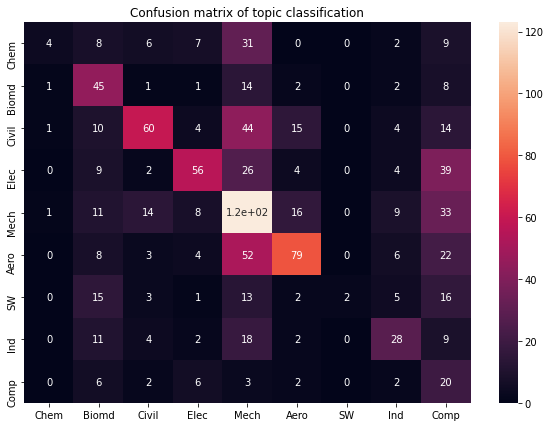

In [0]:
doc_utils.plotConfMatrix(y_test, predictions, model = "NN")

## ArXiv dataset

### Data preprocessing

In [0]:
x_train, y_train, x_test, y_test, dictionary  = doc_utils.processNeuralNetData(arxiv_topic_defs,
                                                                                arxiv_papers,
                                                                                dataset_type = "arxiv",
                                                                                preprocess = 'simple')

### Model train and evaluation

In [0]:
mean_acc = 0
max_acc = 0
acc_list = []
n_runs = 30 

print("Executing",n_runs,"runs of model training/evaluation...\n")

for i in tqdm(range(n_runs)):
    clear_session()

    #Neural Architecture Definition
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(len(dictionary),)))

    model.add(Dense(len(doc_utils.ARXIV_WIKI_TOPICS), activation='softmax'))
    #Model compilation
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])
    #Model training
    hist = model.fit(x_train, y_train, epochs=15,verbose=0)

    model_acc = model.evaluate(x_test, y_test, verbose=0)[1]
    acc_list.append(model_acc)

    if model_acc >= max(acc_list):
        #save best model to date
        model_json = model.to_json()
        with open("arxiv_model.json", "w") as f:
            f.write(model_json)
        model.save_weights("arxiv_model.h5")


print("\nResulting Average accuracy:",np.mean(acc_list))
print("Best accuracy:", max(acc_list))

Executing 30 runs of model training/evaluation...



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  




Resulting Average accuracy: 0.19166666666666668
Best accuracy: 0.2475000023841858


In [0]:
#loading best model obtained
json_f = open('arxiv_model.json', 'r')
best_model_json = json_f.read()
json_f.close()
best_model = model_from_json(best_model_json)
#loading weights
best_model.load_weights("arxiv_model.h5")

# evaluate loaded model on test data
best_model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])
predictions = best_model.predict_classes(x_test) #for later building confusion matrix
print("Model accuracy:",best_model.evaluate(x_test, y_test, verbose=0)[1])

Model accuracy: 0.2475000023841858


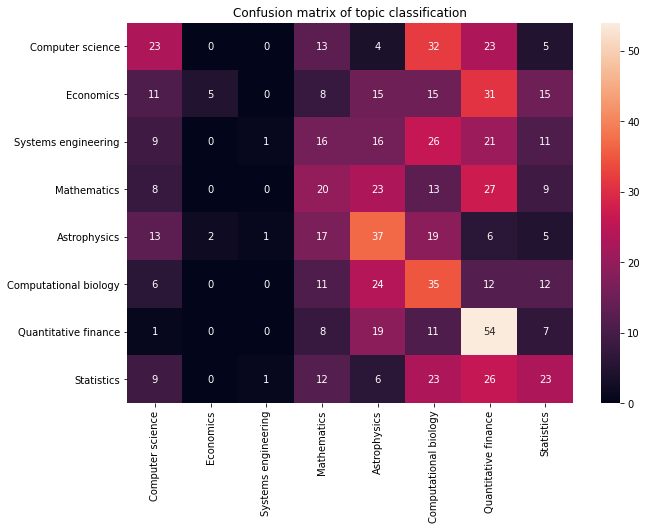

In [0]:
doc_utils.plotConfMatrix(y_test, predictions, model = "NN",dataset_type="arxiv")